In [1]:
import numpy as np
import json
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
import statistics

# Cost and Observations

### Experiment 1: Put the entire criteria dictionary into the prompt (25 criteria to be evaluated by each run of the quantifier). Running the LLM quantifier over 120 samples * 50 seeds (=6000 queries), took about 27 hours, average about 16 seconds per query. However, the returned data quality is poor. Out of 6000 queries, we got 3729 incomplete returned results.

### Note: I started off using variances, but for problem type which has a large range of accepted values and the index do not necessarily reflect any useful ordering, it will have a large variance even though the estimates are generally close enough.

### Note: After analyzing the change in standard deviations, at 18 seeds we seem to be able to achieve a balance between cost and data quality.

### Experiment 2: Evaluate one criterion at a time. We got better returned results, and reduction in mean sample standard deviations.

# Load Criteria

In [2]:
# load the criteria
criteria_file_path = "output/final_filtered_criteria.json"
with open(criteria_file_path) as crit_file:
    criteria = json.load(crit_file)

criteria

{'efficiency': {'description': 'The conciseness of the solution and the use of the most efficient method to solve the problem.',
  'accepted_values': ['inefficient',
   'moderately_efficient',
   'highly_efficient']},
 'accuracy': {'description': 'The correctness of the solution provided for the math problem.',
  'accepted_values': ['0% - Completely incorrect',
   '25% - Partially correct',
   '50% - Mostly correct',
   '75% - Almost correct',
   '100% - Completely correct']},
 'completeness': {'description': 'The extent to which the solution covers all aspects of the problem.',
  'accepted_values': ['0% - Not complete',
   '25% - Partially complete',
   '50% - Mostly complete',
   '75% - Almost complete',
   '100% - Fully complete']},
 'clarity': {'description': 'The ease with which the solution can be understood by the target audience.',
  'accepted_values': ['0% - Not clear',
   '25% - Somewhat clear',
   '50% - Fairly clear',
   '75% - Mostly clear',
   '100% - Very clear']},
 'pre

In [3]:
# convert accepted value to score
level2score = defaultdict(lambda: defaultdict(int))
for criterion in criteria:
     score = 0
     for v in criteria[criterion]["accepted_values"]:
        level2score[criterion][v] = score
        score += 1
print(level2score)

defaultdict(<function <lambda> at 0x150172c00>, {'efficiency': defaultdict(<class 'int'>, {'inefficient': 0, 'moderately_efficient': 1, 'highly_efficient': 2}), 'accuracy': defaultdict(<class 'int'>, {'0% - Completely incorrect': 0, '25% - Partially correct': 1, '50% - Mostly correct': 2, '75% - Almost correct': 3, '100% - Completely correct': 4}), 'completeness': defaultdict(<class 'int'>, {'0% - Not complete': 0, '25% - Partially complete': 1, '50% - Mostly complete': 2, '75% - Almost complete': 3, '100% - Fully complete': 4}), 'clarity': defaultdict(<class 'int'>, {'0% - Not clear': 0, '25% - Somewhat clear': 1, '50% - Fairly clear': 2, '75% - Mostly clear': 3, '100% - Very clear': 4}), 'presentation': defaultdict(<class 'int'>, {'poor': 0, 'fair': 1, 'excellent': 2}), 'steps delineation': defaultdict(<class 'int'>, {'0% - No steps delineated': 0, '25% - Few steps delineated': 1, '50% - Some steps delineated': 2, '75% - Most steps delineated': 3, '100% - All steps delineated': 4}), 

# Experiment 1: All 25 criteria in one prompt

In [4]:
num_outputs = 120
num_seeds = 50

results = defaultdict(lambda: defaultdict(list)) # result[criterion][game] gives a list of 50 scores for that game 

incomplete_dict_error_count = 0
quantified_result_errors = defaultdict(lambda: defaultdict(str))

for seed in range(num_seeds):
    # Load outcome data for the current seed
    with open(f'output/old/evaluated_problems-{seed}.json', 'r') as file:
        outcome = json.load(file)

        for game in outcome:
            gameid = game.strip(".json")
            quantified_string = outcome[game]['estimated_performance']
            if quantified_string.rfind('}') != -1:
                quantified_string_cleaned = quantified_string[quantified_string.index('{'):quantified_string.rfind('}') + 1]
            else:
                quantified_string_cleaned = quantified_string[quantified_string.index('{'):]
            # This portion is not needed if previous results are properly dumped as json
            quantified_string_cleaned = quantified_string_cleaned.replace("'", '"')
            quantified_string_cleaned = quantified_string_cleaned[:-1].strip().strip(",") + '}'
            try:
                quantified_result = json.loads(quantified_string_cleaned)
            except:
                print(quantified_string_cleaned)
                continue
                
            if len(quantified_result) < 25:
                incomplete_dict_error_count += 1
            for criterion in quantified_result:
                cleaned_criterion = criterion.strip()
                if cleaned_criterion not in criteria:
                    continue
                try:
                    results[cleaned_criterion][gameid].append(level2score[cleaned_criterion][quantified_result[criterion]])
                except:
                    print(cleaned_criterion)

{"efficiency": "moderately_efficient", "accuracy": "100% - Completely correct", "completeness": "100% - Fully complete", "clarity": "75% - Mostly clear", "presentation": "fair", "steps delineation": "75% - Most steps delineated", "response time": "16-30 sec", "notations": "consistent", "step explanation": "most steps", "error handling": "Handled most errors", "use of methods": "Excellent use", "level appropriateness": "Appropriate", "solution depth": "Detailed", "terminology": "Appropriate", "reliability": "Mostly Trusted", "calculation error": "No errors", "creativity": "moderately novel", "relevance": "Highly relevant", "simplification": "Mostly", "handling constraints": "Fully respected", "problem type": "Counting & Probability", "adaptability": "Moderate", "problem level": "Level 5", "solution approach": "Appropriate", "correct reasoning": "100%", "user satisfaction": None}
{"efficiency": "highly_efficient", "accuracy": "100% - Completely correct", "completeness": "100% - Fully com

In [5]:
print(incomplete_dict_error_count)

6


## Sample Standard Deviations

In [6]:
stdevs = defaultdict(lambda: defaultdict(float))

for criterion in results:
    for game in results[criterion]:
        if len(results[criterion][game]) < 2:
            continue
        stdevs[criterion][game] = statistics.stdev(results[criterion][game])

## Present the Statistics

### print average sample standard deviations for each criterion

In [7]:
stdevs_list = {}
for criterion in stdevs:
    stdevs_list[criterion] = []
    for game in stdevs[criterion]:
        stdevs_list[criterion].append(stdevs[criterion][game])

In [8]:
sorted_stdevs = sorted(stdevs_list.items(), key=lambda x:statistics.mean(x[1]), reverse=True)

for entry in sorted_stdevs:
    print(f"criterion {entry[0]}: {statistics.mean(entry[1])}, number of data points: {len(entry[1])}")

criterion step explanation: 0.7482812137175324, number of data points: 120
criterion level appropriateness: 0.7441394990774737, number of data points: 120
criterion steps delineation: 0.7113661997812873, number of data points: 120
criterion adaptability: 0.6975816259615314, number of data points: 119
criterion problem type: 0.6950098848103101, number of data points: 119
criterion simplification: 0.6770982092297695, number of data points: 119
criterion error handling: 0.6537719796804059, number of data points: 120
criterion completeness: 0.6409265518066248, number of data points: 120
criterion clarity: 0.634803281393747, number of data points: 120
criterion solution depth: 0.6221584617463936, number of data points: 120
criterion correct reasoning: 0.6069209959400325, number of data points: 119
criterion accuracy: 0.557313776845949, number of data points: 120
criterion efficiency: 0.43982479004763475, number of data points: 120
criterion creativity: 0.40735991748376654, number of data po

### plot sample standard deviations for each criterion

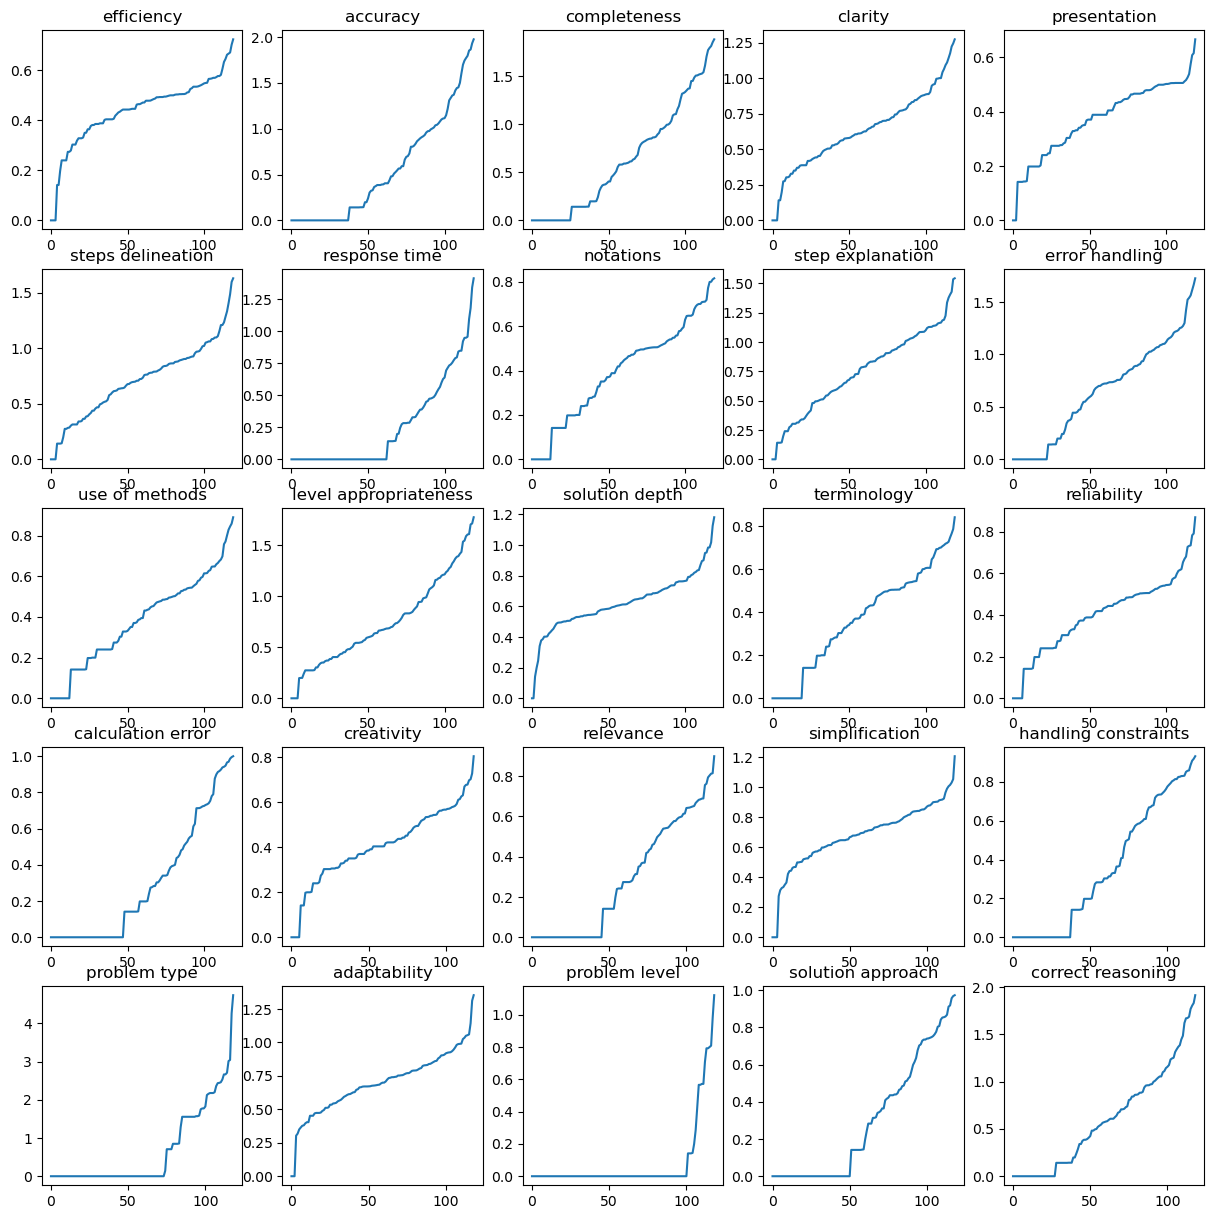

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for index, criterion in enumerate(stdevs_list):
    axs[index//5, index%5].plot(sorted(stdevs_list[criterion]))
    axs[index//5, index%5].title.set_text(criterion)


## Check the "optimal" number of seeds

In [10]:
def get_mean_stdev_for_num_seeds_exp1(num_seeds):
    results = defaultdict(lambda: defaultdict(list)) # result[criterion][game] gives a list of num_seeds scores for that game 
    
    for seed in range(num_seeds):
        # Load outcome data for the current seed

        with open(f'output/old/evaluated_problems-{seed}.json', 'r') as file:
            outcome = json.load(file)
    
            for game in outcome:
                gameid = game.strip(".json")
                quantified_string = outcome[game]['estimated_performance']
                if quantified_string.rfind('}') != -1:
                    quantified_string_cleaned = quantified_string[quantified_string.index('{'):quantified_string.rfind('}') + 1]
                else:
                    quantified_string_cleaned = quantified_string[quantified_string.index('{'):]
                # This portion is not needed if previous results are properly dumped as json
                quantified_string_cleaned = quantified_string_cleaned.replace("'", '"')
                quantified_string_cleaned = quantified_string_cleaned[:-1].strip().strip(",") + '}'
                try:
                    quantified_result = json.loads(quantified_string_cleaned)
                except:
                    continue
                    
                for criterion in quantified_result:
                    cleaned_criterion = criterion.strip()
                    if cleaned_criterion not in criteria:
                        continue
                    try:
                        results[cleaned_criterion][gameid].append(level2score[cleaned_criterion][quantified_result[criterion]])
                    except:
                        continue
        
    stdevs = defaultdict(lambda: defaultdict(float))
    
    for criterion in results:
        for game in results[criterion]:
            if len(results[criterion][game]) < 2:
                continue
            stdevs[criterion][game] = statistics.stdev(results[criterion][game])
        
    stdevs_list = {}
    for criterion in stdevs:
        stdevs_list[criterion] = []
        for game in stdevs[criterion]:
            stdevs_list[criterion].append(stdevs[criterion][game])

    mean_stdevs = {}
    for criterion in stdevs_list:
        mean_stdevs[criterion] = statistics.mean(stdevs_list[criterion])

    return mean_stdevs

In [11]:
# check when is the ordering of the mean sample standard deviations stable
for num_seeds in range(5, 50):
    prev_stdevs = get_mean_stdev_for_num_seeds_exp1(num_seeds - 1)
    cur_stdevs = get_mean_stdev_for_num_seeds_exp1(num_seeds)

    sorted_prev_stdevs = [i[0] for i in sorted(prev_stdevs.items(), key=lambda x:x[1])]
    sorted_cur_stdevs = [i[0] for i in sorted(cur_stdevs.items(), key=lambda x:x[1])]

    if sorted_prev_stdevs == sorted_cur_stdevs:
        print(num_seeds)


31
36
37
38
40
42
43
44
46
47


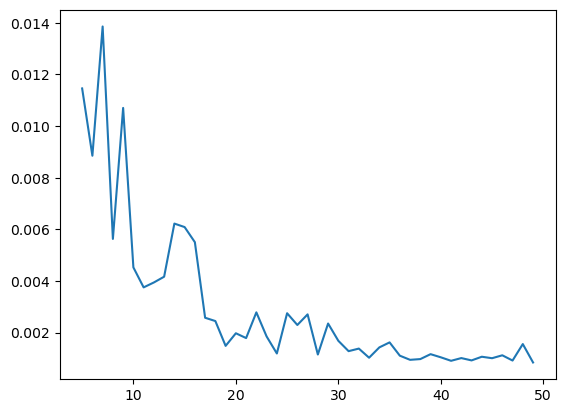

In [12]:
# check when is the biggest change in mean sample standard deviations small enough (excluding problem_type)
average_change_in_mean_stdevs = {}

for num_seeds in range(5, 50):
    prev_stdevs = get_mean_stdev_for_num_seeds_exp1(num_seeds - 1)
    cur_stdevs = get_mean_stdev_for_num_seeds_exp1(num_seeds)

    change_in_mean_stdevs = {}

    for criterion in prev_stdevs:
        if criterion == "problem type":
            continue
        change_in_mean_stdevs[criterion] = cur_stdevs[criterion] - prev_stdevs[criterion]

    sorted_change_in_mean_stdevs = [abs(i[1]) for i in sorted(change_in_mean_stdevs.items(), key=lambda x: abs(x[1]), reverse=True)]

    average_change_in_mean_stdevs[num_seeds] = statistics.mean(sorted_change_in_mean_stdevs)

plt.plot(average_change_in_mean_stdevs.keys(), average_change_in_mean_stdevs.values())

# Experiment 2: each prompt takes only one criterion

In [13]:
def get_stdevs_for_num_seeds_exp2(num_seeds):
    results = defaultdict(lambda: defaultdict(list)) # result[criterion][game] gives a list of num_seeds scores for that game 
    key_errors = defaultdict(int)
    
    for seed in range(num_seeds):
        # Load outcome data for the current seed
        with open(f'output/evaluated_problems-{seed}.json', 'r') as file:
            outcome = json.load(file)
    
            for game in outcome:
                gameid = game.strip(".json")
                quantified_result = json.loads(outcome[game])['estimated_performance']

                for criterion in quantified_result:
                    cleaned_level = quantified_result[criterion].strip("'")
                    results[criterion][gameid].append(level2score[criterion][cleaned_level])
        
    stdevs = defaultdict(lambda: defaultdict(float))
    
    for criterion in results:
        for game in results[criterion]:
            if len(results[criterion][game]) < 2:
                continue
            stdevs[criterion][game] = statistics.stdev(results[criterion][game])
        
    stdevs_list = {}
    for criterion in stdevs:
        stdevs_list[criterion] = []
        for game in stdevs[criterion]:
            stdevs_list[criterion].append(stdevs[criterion][game])

    mean_stdevs = {}
    for criterion in stdevs_list:
        mean_stdevs[criterion] = statistics.mean(stdevs_list[criterion])

    return (stdevs_list, mean_stdevs, key_errors, results)

In [14]:
stdevs_list, mean_stdevs, key_errors, results = get_stdevs_for_num_seeds_exp2(num_seeds=18)

sorted_stdevs = sorted(stdevs_list.items(), key=lambda x:statistics.mean(x[1]), reverse=True)

for entry in sorted_stdevs:
    print(f"criterion {entry[0]}: {statistics.mean(entry[1])}, number of data points: {len(entry[1])}")

criterion problem type: 2.357437123529776, number of data points: 126
criterion step explanation: 0.5304532387160793, number of data points: 126
criterion level appropriateness: 0.5013985980605417, number of data points: 126
criterion error handling: 0.4750492671726052, number of data points: 126
criterion clarity: 0.46837125603690294, number of data points: 126
criterion correct reasoning: 0.4530248613092668, number of data points: 126
criterion solution depth: 0.41854619232105866, number of data points: 126
criterion steps delineation: 0.41274788464410334, number of data points: 126
criterion completeness: 0.39283084251396033, number of data points: 126
criterion adaptability: 0.34220647414342376, number of data points: 126
criterion simplification: 0.3416106071311001, number of data points: 126
criterion accuracy: 0.33933775924133314, number of data points: 126
criterion presentation: 0.28123738401954584, number of data points: 126
criterion reliability: 0.279958392288476, number of

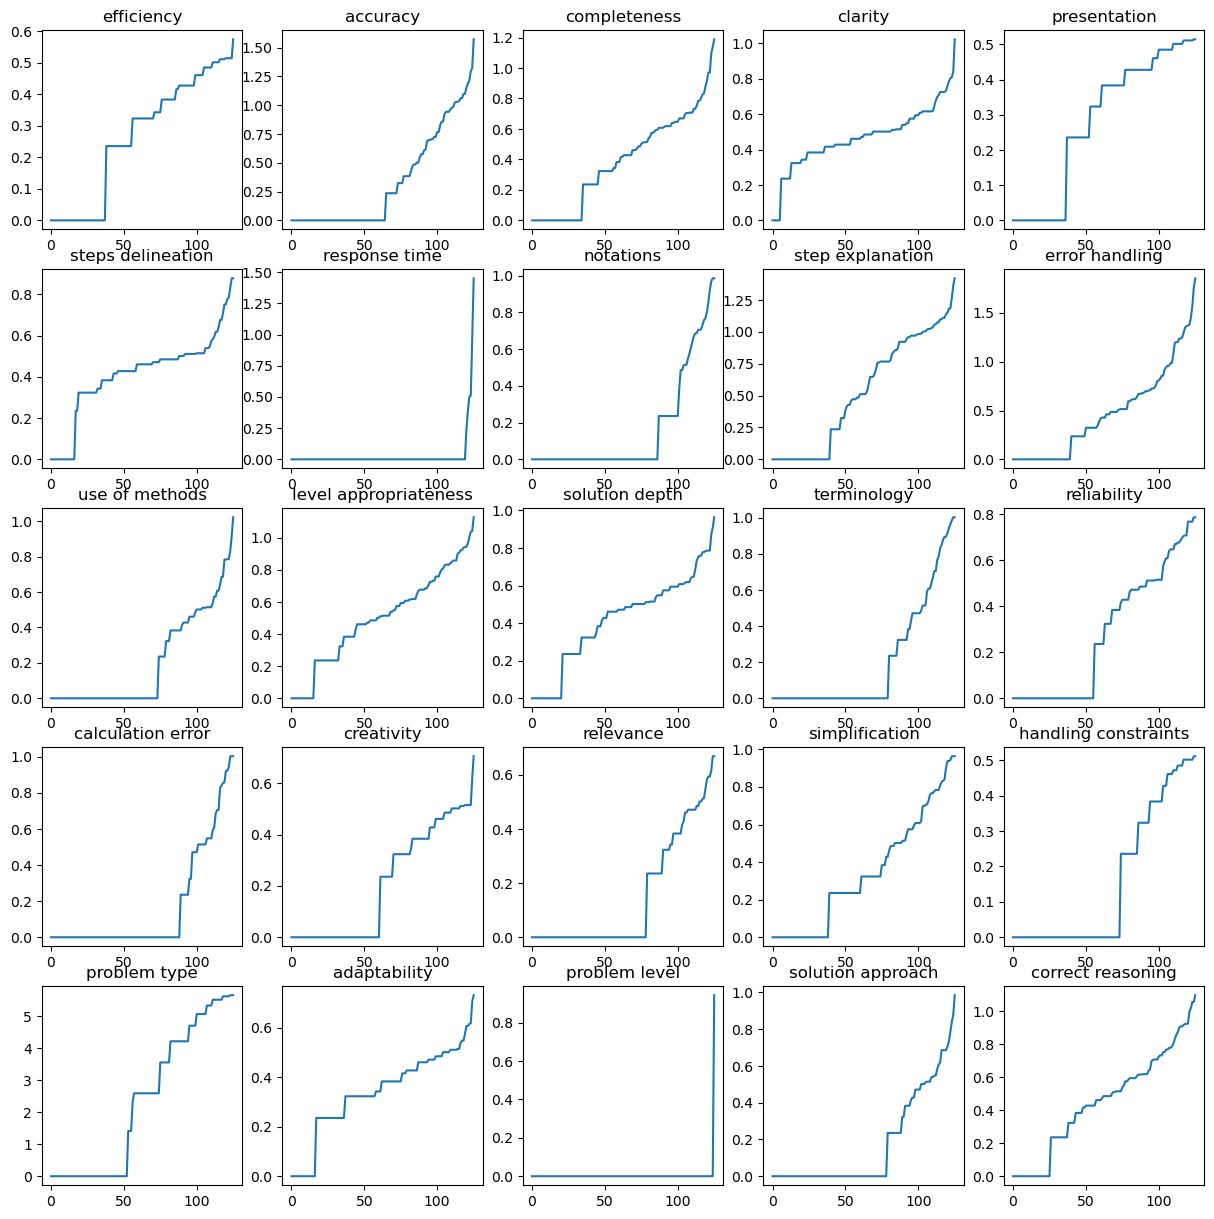

In [15]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for index, criterion in enumerate(stdevs_list):
    axs[index//5, index%5].plot(sorted(stdevs_list[criterion]))
    axs[index//5, index%5].title.set_text(criterion)

In [16]:
# check when is the ordering of the mean sample standard deviations stable
for num_seeds in range(5, 18):
    prev_stdevs = get_stdevs_for_num_seeds_exp2(num_seeds - 1)[1]
    cur_stdevs = get_stdevs_for_num_seeds_exp2(num_seeds)[1]

    sorted_prev_stdevs = [i[0] for i in sorted(prev_stdevs.items(), key=lambda x:x[1])]
    sorted_cur_stdevs = [i[0] for i in sorted(cur_stdevs.items(), key=lambda x:x[1])]

    if sorted_prev_stdevs == sorted_cur_stdevs:
        print(num_seeds)

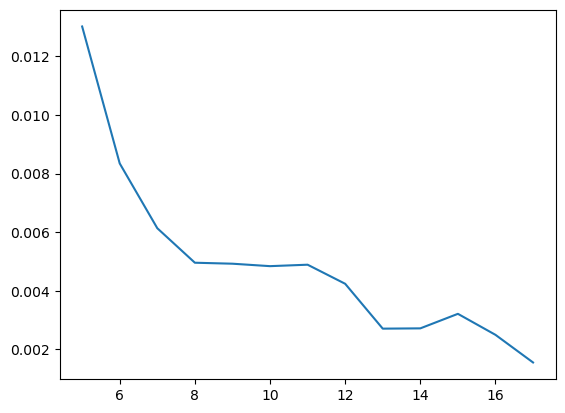

In [17]:
# check when is the biggest change in mean sample standard deviations small enough (excluding problem_type)
average_change_in_mean_stdevs = {}

for num_seeds in range(5, 18):
    prev_stdevs = get_stdevs_for_num_seeds_exp2(num_seeds - 1)[1]
    cur_stdevs = get_stdevs_for_num_seeds_exp2(num_seeds)[1]

    change_in_mean_stdevs = {}

    for criterion in prev_stdevs:
        if criterion == "problem type":
            continue
        change_in_mean_stdevs[criterion] = cur_stdevs[criterion] - prev_stdevs[criterion]

    sorted_change_in_mean_stdevs = [abs(i[1]) for i in sorted(change_in_mean_stdevs.items(), key=lambda x: abs(x[1]), reverse=True)]

    average_change_in_mean_stdevs[num_seeds] = statistics.mean(sorted_change_in_mean_stdevs)

plt.plot(average_change_in_mean_stdevs.keys(), average_change_in_mean_stdevs.values())